In [2]:
#Load some packages to be used in this program
import matplotlib as plt
import scipy  as sp
import numpy  as np
import xarray as xr
import pyart  as pyart
import os
import glob
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy as cartopy
%pylab inline
import cartopy.io.shapereader as shpreader
import netCDF4 as netCDF4
import pytz
import imageio
from PIL import Image
import moviepy.editor as mp
import time

from matplotlib.animation import FuncAnimation
#import matplotlib.animation as animation

import gc


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/sransom/pyart/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/sransom/pyart/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


Populating the interactive namespace from numpy and matplotlib


/home/sransom/.conda/envs/clouds_env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
#load sample data file and extract some universal properties of the data for future usage
radar = pyart.io.read('/nfs/gce/projects/digr/xsapr_nsa/BRW190120002403.RAWTA32.maint')
rlon = -radar.longitude['data'][0]
rlat = radar.latitude['data'][0]
keys = radar.fields.keys()
coastlines = cartopy.feature.NaturalEarthFeature(
    category='physical', name='coastline',
    scale='10m', facecolor='grey')
projection = ccrs.Mercator(central_longitude=rlon,
                           min_latitude=rlat-5.,
                           max_latitude=rlat+5.)

In [4]:
#Get that gatefilter goin yall
def gatefilter(radar):
    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.exclude_above('total_power', 40)
    gatefilter.exclude_below('total_power', 10)
    #gatefilter.exclude_above('reflectivity', 20)
    #gatefilter.exclude_below('reflectivity', 0)
    #gatefilter.exclude_above('velocity',  2)
    #gatefilter.exclude_below('velocity', -2)
    return gatefilter

In [5]:
# Read all files of
#jan_20_evening = glob.glob('/nfs/gce/projects/digr/xsapr_nsa/BRW1901202*')
#filestart = 12
jan_20_evening = glob.glob('/nfs/gce/projects/digr/xsapr_nsa/*')
#jan_20_evening = jan_20_evening[0:10]
jan_20_length = len(jan_20_evening)
jan_20_evening.sort()

In [6]:
#make a mask to cover up ice-like radar signatures produced by the pipeline
#upload b&w image of the land/sea pattern
utqiagvik_land = imageio.imread('/home/sransom/pyth/utqiagvik mask.png')[:,:,0]/255
stationary_ice = imageio.imread('/home/sransom/pyth/stationary mask.png')[:,:,0]/255
#define a function to create a mask based on this png
def automask(im):
    width =  np.shape(im)[1]        # get image size
    height =  np.shape(im)[0]
    mask = np.full((height,width), True) # create array of trues from which to rm land points
    tran = im[0,0]   # transparent top-left
    for y in range(height):
        for x in range(width):
            if im[y,x] == tran:
                mask[y,x] = False  # mask on the point if it is ocean
    return mask[-1::-1,::]
#Make a mask out of the uploaded png
landmask = automask(utqiagvik_land)
stationarymask = automask(stationary_ice)

#Make a function to apply the landmask produced above
def rm_feature(feature,gridded_radar):
    totalpower = gridded_radar.fields['total_power']['data']
    reflectvty = gridded_radar.fields['reflectivity']['data']
    for a in range(totalpower.shape[0]):
        gridded_radar.fields['reflectivity']['data'][a]=np.ma.masked_where(feature,reflectvty[a,:,:])
        gridded_radar.fields['total_power']['data'][a] =np.ma.masked_where(feature,totalpower[a,:,:])
        
    return gridded_radar


In [7]:
#grid each radar file and make a file for the grid

resolution = 401 #Define how many pixels wide and long the graphs should be
def produce_grid(item):
    print('loading radar...')
    radar = pyart.io.read(item)
    print('radar loading complete \ncreating grid...')
    gf = gatefilter(radar)
    totalpower = radar.fields['total_power']['data']
    radar.fields['reflectivity']['data'] = np.ma.masked_where(gf.gate_excluded, totalpower)
    radar.fields['total_power']['data']  = np.ma.masked_where(gf.gate_excluded, totalpower)
    grid = pyart.map.grid_from_radars([radar],
                                          (16,resolution,resolution), ((0,15000),(-20000, 20000), (-20000, 20000)),#(-lat_extent, lat_extent), (-lon_extent,lon_extent)),
                                          fields = ['reflectivity', 'total_power'], weighting_function = 'Nearest',
                                          gatefilters = [gf],
                                          min_roi = 250.0,
                                          gridding_algo='map_gates_to_grid')
    #Now apply the land mask to these grids
    #grid = rm_feature(landmask, grid)
    grid = rm_feature(stationarymask, grid) #actually just apply mask of area which isn't moving since non-moving parts are less prominent on radar

    del radar
    return grid


    #except RuntimeError:
    #    print(grid_path + 'is bad')
    #    print('Failed item\'s number ')
        #continue

    

In [ ]:
progress = 0 # filestart
start_time = time.time()
for item in jan_20_evening:
    #write grid:
    grid = produce_grid(item)
    print('writing grid')
    
    grid_path = '/home/sransom/pyth/EG_Utqiagvik_gridded/sans_ice/grids/' + item[33:48] + '.nc'
    #try:
    grid.write(grid_path)
    progress += 1
    #print('gridded file '+ str(progress)+ ', which is item ' + str(progress-filestart) + ' of ' + str(jan_20_length))
    print('gridded file '+ str(progress) + ' of ' + str(jan_20_length) + ' (' + str(progress/jan_20_length*100)[0:4] + '% done)' )
    
    #if progress-filestart != jan_20_length:
    #    print('restarting gridding progress')
    
    #Calculate percentage done
    elapsed = time.time() - start_time
    timeperfile = elapsed/progress
    timeleft = (len(jan_20_evening)-progress)*timeperfile
    print('Estimated time remaining: ' + str(timeleft/60) + ' minutes')
    

    del grid
    
print('done')
    #radurr = pyart.io.read_grid(grid_path)

In [8]:
#Define function to add fields to the empty target xarray
def xrmake(target, radarc, time,field):
    if target != xr.Dataset():
        raise ValueError('git gud m9, target input must be an empty xarray, try target = xr.Dataset() instead')
    lon, lat = radarc.get_point_longitude_latitude()
    height = radarc.point_z['data'][:,0,0]
    time = np.array([ netCDF4.num2date(radarc.time['data'][0], radarc.time['units'])])
    this_data = radarc.fields[field]['data']
    this_data = np.ma.filled(this_data, np.nan)
    my_data = xr.DataArray(np.expand_dims(this_data,0),
                  dims = ('time', 'z', 'y', 'x'),
                  coords = {'time' : (['time'], time),
                            'z' : (['z'], height),
                            'lat' :(['y','x'], lat),
                            'lon' : (['y','x'],lon),
                             'y' : (['y'],lat[:,0]),
                             'x' : (['x'],lon[0,:])})
    
    if field is not 'data':
        my_data.attrs.update({field: radarc.fields[field]})
    target[field] = my_data
    target.lon.attrs = [('long_name', 'longitude of grid cell center'), ('units', 'degrees_east')]
    target.lat.attrs = [('long_name', 'latitude of grid cell center'),  ('units', 'degrees_north')]
    target.z.attrs['long_name'] = field
    target.z.attrs['units'] = radarc.fields[field]['units']
    target.z.encoding['_FillValue'] = -9999.0
    target.lat.encoding['_FillValue'] = -9999.0
    target.lon.encoding['_FillValue'] = -9999.0
    return target


In [9]:
def generate_grid_time_begin(grid):
    """ Return time begin in datetime instance. """
    times = grid.time['data'][0]
    units = grid.time['units']
    if 'calendar' in grid.time:
        calendar = grid.time['calendar']
    else:
        calendar = 'standard'
    return num2date(times, units, calendar)


In [10]:
# Write a function to generate a title based for a given frame
def title_make(inputt):
    #Get the date at the start of collection
    #index_at_start = inputt.sweep_start_ray_index['data'][0]
    if 'calendar' in inputt.time:
        calendar = inputt.time['calendar']
    else:
        calendar = 'standard'
    time_at_start_of_radar = pyart.io.cfradial.netCDF4.num2date(inputt.time['data'][0], 
                                      inputt.time['units'], calendar)
    
    #make a nice time stamp
    pacific = pytz.timezone('US/Alaska')
    local_time = pacific.fromutc(time_at_start_of_radar)
    fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
    print('fancy date string: ' + fancy_date_string)

    #Give it a nice title
    title = 'X-SAPR Utqiagvik \n' + fancy_date_string
    
    return title



In [11]:
gridfiles = glob.glob('/home/sransom/pyth/EG_Utqiagvik_gridded/sans_ice/grids/*')[0:jan_20_length]
gridfiles.sort()

In [12]:
#Define animation function
def animate(nframe, field, minv, maxv):
    plt.clf()
    nfile = gridfiles[nframe]
    radarc = pyart.io.read_grid(nfile)
    print('frame ' + str(nframe) + ' of ' + str(len(gridfiles)) + ' animated')
     
    #radarc = rm_feature(stationarymask, radarc)
    #radarc = rm_feature(landmask, radarc)
    title = title_make(radarc)
    
    radar = xr.Dataset() #define an empty xr in which to put data
    ds = xrmake(radar, radarc, time, field) #add each field to the xr made above
    projection = ccrs.PlateCarree()
    my_ax = plt.subplot(projection=projection)

    pc = ds[field][0].sel(z=10, method='nearest').plot.pcolormesh(
        ax=my_ax,
        x='lon', y='lat',
        vmin=minv, vmax=maxv,
        cmap=pyart.graph.cm_colorblind.HomeyerRainbow)

    #Set lat an lon lines and aspect ratios
    lat_lines = np.arange(np.around(ds.lat.min(), decimals=1), ds.lat.max(), .05)
    lon_lines = np.arange(np.around(ds.lon.min(),decimals=1), ds.lon.max(), .2)
#    my_ax.set_xticks(lon_lines, crs = projection)
#    my_ax.set_yticks(lat_lines, crs = projection)

    # Make it not stretchy
    my_ax.set_aspect(aspect = 2)

    # Change labels
#    my_ax.set_xlabel("Longitude ($^\circ$)")
#    my_ax.set_ylabel("Latitude ($^\circ$)")
#    my_ax.set_title(field + '\n' + title)

    # Crop all this
    my_ax.set_xlim(-157.0, -156.2)
    my_ax.set_ylim(71.2, 71.5)
    
    bbox_inches='tight'

    #Add coastline
    #my_ax.add_feature(coastlines, linestyle='-', edgecolor='k', linewidth=1)

In [ ]:
#Animate it and save it
vmin_ = (-30, -30, -15,  0, -1, -1, 0, 0, -10)
vmax_ = ( 50,  30,  15,  5,  8,  1, 1, 1, 160)

vmin_ = ( 0,  0)
vmax_ = (35, 35)

propnum = 0

keys = ['total_power', 'reflectivity']
field = 'reflectivity'

fig = plt.figure(figsize=(12, 8))
vmin = vmin_[propnum]
vmax = vmax_[propnum]
propnum = propnum + 1
anim_klot = FuncAnimation(fig, animate, fargs = (field, vmin, vmax), frames=len(gridfiles))
#anim_klot.save('/home/sransom/pyth/EG_Utqiagvik_gridded/' + field +'_sans_ice.gif', writer = 'imagemagick', fps=2)
anim_klot.save('/home/sransom/pyth/EG_Utqiagvik_gridded/sans_ice/' + field + '.gif', writer = 'imagemagick', fps=2)
print('                                                                   ' + str(field) + ' gif written')
plt.close()

In [13]:
raise ValueError('yeeet')

ValueError: yeeet

In [21]:
resolution = 401
radar = pyart.io.read(jan_20_evening[2])
print('radar loading complete \ncreating grid...')
gf = gatefilter(radar)
totalpower = radar.fields['total_power']['data']
#radar.fields['reflectivity']['data'] = np.ma.masked_where(gf.gate_excluded, totalpower)
radar.fields['total_power']['data']  = np.ma.masked_where(gf.gate_excluded, totalpower)
mygrid = pyart.map.grid_from_radars([radar],
                                      (16,resolution,resolution), ((0,15000),(-20000, 20000), (-20000, 20000)),#(-lat_extent, lat_extent), (-lon_extent,lon_extent)),
                                      fields = ['reflectivity', 'total_power'], weighting_function = 'Nearest',
                                      gatefilters = [gf],
                                      min_roi = 250.0,
                                      gridding_algo='map_gates_to_grid')

radar loading complete 
creating grid...


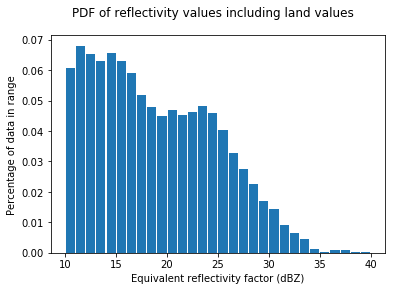

In [22]:
#make hist of powerspectrum sans land
egdata = np.ma.getdata(mygrid.fields['total_power']['data'])
egdata = egdata.ravel()
egdata = egdata[~np.isnan(egdata)]

plt.hist(egdata, bins= np.linspace(10,40,31), rwidth = .9, density = True)
plt.xlabel('Equivalent reflectivity factor (dBZ)')
plt.ylabel('Percentage of data in range')
plt.suptitle('PDF of reflectivity values including land values')
plt.savefig('/home/sransom/pyth/papergraphics/power_spectrum_with_land.png', bbox_inches = 'tight')

In [ ]:
resolution = 401
radar = pyart.io.read(jan_20_evening[2])
print('radar loading complete \ncreating grid...')
eggrid = pyart.map.grid_from_radars([radar],
                                      (16,resolution,resolution), ((0,15000),(-20000, 20000), (-20000, 20000)),#(-lat_extent, lat_extent), (-lon_extent,lon_extent)),
                                      fields = ['reflectivity', 'total_power'], weighting_function = 'Nearest',
                                      min_roi = 250.0,
                                      gridding_algo='map_gates_to_grid')

In [1]:
#make hist of powerspectrum sans land
egdata = np.ma.getdata(eggrid.fields['total_power']['data'])
egdata = egdata.ravel()
egdata = egdata[~np.isnan(egdata)]
egdata = egdata[egdata != 0]

plt.hist(egdata, bins= np.linspace(-21,40), rwidth = .9, density = True)
plt.xlabel('Equivalent reflectivity factor (dBZ)')
plt.ylabel('Percentage of data in range')
plt.suptitle('PDF of reflectivity values including land values')
#plt.savefig('/home/sransom/pyth/papergraphics/power_spectrum_with_land.png', bbox_inches = 'tight')

NameError: name 'np' is not defined

In [ ]:
#make hist of power spectrum
resolution = 401
radar = pyart.io.read(jan_20_evening[2])
eggrid = pyart.map.grid_from_radars([radar],
                                      (16,resolution,resolution), ((0,15000),(-20000, 20000), (-20000, 20000)),#(-lat_extent, lat_extent), (-lon_extent,lon_extent)),
                                      fields = ['reflectivity', 'total_power'],
                                      weighting_function = 'Nearest',
                                      #gatefilters = [gf],
                                      min_roi = 250.0,
                                      gridding_algo='map_gates_to_grid'
                                      )
egdata  = np.ma.getdata(eggrid.fields['reflectivity']['data'])
egdata = egdata.ravel()
egdata = egdata[~np.isnan(egdata)]

plt.hist(egdata, bins= np.linspace(-21,40,61), rwidth = .9, density = True)
plt.xlabel('Equivalent reflectivity factor (dBZ)')
plt.ylabel('Percentage of data in range')
plt.suptitle('PDF of reflectivity values including land values')
#plt.savefig('/home/sransom/pyth/papergraphics/power_spectrum_sans_mask.png', bbox_inches = 'tight')

In [ ]:
np.shape(egdata)

In [ ]:
#create grids of differences between days
field = 'reflectivity'
radar1 = pyart.io.read_grid(gridfiles[0])
data1 = data2 = np.zeros((401,401,16))
def diff_make(radar1, radar2):
    #combine mask of radar2's data and radar1's data to make new mask
    bothmask = np.logical_or(radar2.fields[field]['mask'] , radar1.fields[field]['mask'])
    data1[:,:,:] = radar1.fields[field]['data']
    data1[data1==-9999.] = 0
    data2[:,:,:] = radar2.fields[field]['data']
    data2[data2==-9999.] = 0
    #data1 = np.ma.masked_where(mask1,np.ma.getdata(radar1))
    #data2 = np.ma.masked_where(mask2,np.ma.getdata(radar2))
    #data1[mask1==True] = 0
    #data2[mask2==True] = 0
    #subtract masked data sets
    diff = np.absolute(data2-data1)
    #convert field corresponding with reflectivity's data to diff of radar2's field's data and radar1's field' data
    #make radar2 into radar1 to be used in next iteration
    return diff, bothmask

In [ ]:
field = 'reflectivity'
radar1 = pyart.io.read_grid(gridfiles[4])
radar2 = pyart.io.read_grid(gridfiles[5])
data1 = data2 = np.zeros((16,401,401))
data1[:,:,:] = radar1.fields[field]['data']
radar1.fields[field]['data'][data1==-9999.] = 0
data2[:,:,:] = radar2.fields[field]['data']
radar2.fields[field]['data'][data2==-9999.] = 0
diff = data2-data1
plt.pcolormesh(sp.sum(diff,axis=0))


In [ ]:
b = radar2.fields['reflectivity']['data'] - radar1.fields['reflectivity']['data']
plt.pcolormesh(sp.sum(b, axis=0))

In [ ]:
diff = data1 - data2
diff_masked = np.ma.masked_array(diff, mask = diff == 0)
diff_masked = np.ma.compressed(diff_masked)
plt.pcolormesh(sp.sum(diff_masked, axis=0))

In [ ]:
yeet = np.ma.masked_array(radar1.fields['reflectivity']['data'],
                          mask = radar1.fields['reflectivity']['data'] == -9999.)
woke = np.ma.masked_array(radar2.fields['reflectivity']['data'],
                          mask = radar2.fields['reflectivity']['data'] == -9999.)

diff = yeet - woke
print(diff)

In [ ]:
plt.pcolormesh(sp.mean(radar1.fields[field]['data'],axis=0))

In [ ]:
radar1 = pyart.io.read_grid(gridfiles[0])
egradar = radar1 #create duplicate of next radar file to convert into diff file

for a in range(0,len(gridfiles)-1):
    radar2 = pyart.io.read_grid(gridfiles[a]) #load next radar file
    diff, bothmask = diff_make(radar1,radar2)
    egradar.fields[field]['data'] = np.ma.masked_array(diff,bothmask)
    #egradar.fields[field]['data'] = diff
    #egradar.fields[field]['mask'] = bothmask
    egradar.write('/home/sransom/pyth/EG_Utqiagvik_gridded/diff_animation/diffs/' + gridfiles[a][46:-3] + '.nc')
    #make radar2 into radar1 to be used in next iteration
    radar1 = radar2
    print('diff ' + str(a) + ' printed')

In [ ]:
#Animate it and save it
vmin_ = (-30, -30, -15,  0, -1, -1, 0, 0, -10)
vmax_ = ( 50,  30,  15,  5,  8,  1, 1, 1, 160)

vmin_ = (-10,  0)
vmax_ = ( 10, 35)

propnum = 0

keys = ['total_power', 'reflectivity']
keys = 'reflectivity'


for field in keys:
    fig = plt.figure(figsize=(12, 8))
    vmin = vmin_[propnum]
    vmax = vmax_[propnum]
    propnum = propnum + 1
    anim_klot = FuncAnimation(fig, animate, fargs = (field, vmin, vmax), frames=len(gridfiles))
    #anim_klot.save('/home/sransom/pyth/EG_Utqiagvik_gridded/' + field +'_sans_ice.gif', writer = 'imagemagick', fps=2)
    anim_klot.save('/home/sransom/pyth/EG_Utqiagvik_gridded/diff_animation/' + field + '.gif', writer = 'imagemagick', fps=2)
    print('                                                                   ' + str(field) + ' gif written')
    plt.close()

In [ ]:
raise ValueError('stop')

In [ ]:
files = glob.glob('/home/sransom/pyth/EG_Utqiagvik_gridded/sans_ice/grids/*')[0:jan_20_length]
files.sort()

In [ ]:
#create file of all data for detecting which things aren't moving
all_data = np.zeros((401,401,len(files)*16))
for a in range(0,20):
    grid = pyart.io.read_grid(gridfiles[a])
    data = grid.fields['total_power']['data']
    for b in range(0,15):
        all_data[:,:,16*a + b] = data[b,:,:]
    print('yeet ' + str(a) + ' of 20')

#Replace mask fill values with something the computer can work with
all_data[all_data == -9999.] = 1


deviation = sp.std(all_data, axis = 2,ddof = 0)
#remove data that never changes (the already masked data), as well as data with larger stds (stationary ice)
deviation[deviation == 0] = np.nan
#stationary_mask = deviation > .1
#del deviation
#del all_data

#deviation = np.ma.masked_where(landmask,deviation)

#Make mask of data which is changing consistently
#automask(deviation)

In [ ]:
plt.pcolormesh(deviation)

In [ ]:
plt.hist(np.hstack(deviation[~np.isnan(deviation)]), bins = 30)
plt.grid(axis = 'y', alpha = .75)
plt.show()
plt.close()

In [ ]:
## Make animation without the stationary ice

In [ ]:
#Make mask of ice
utqiagvik_ice = imageio.imread('/home/sransom/pyth/stationary mask.png')[:,:,0]/255
icebank_mask = automask(utqiagvik_ice)

In [ ]:
#Animate it and save it
vmin_ = (-30, -30, -15,  0, -1, -1, 0, 0, -10)
vmax_ = ( 50,  30,  15,  5,  8,  1, 1, 1, 160)

vmin_ = ( 0,  0)
vmax_ = (35, 35)

propnum = 0

keys = ['total_power', 'reflectivity']

for field in keys:
    fig = plt.figure(figsize=(12, 8))
    vmin = vmin_[propnum]
    vmax = vmax_[propnum]
    propnum = propnum + 1
    anim_klot = FuncAnimation(fig, animate2, fargs = (field, vmin, vmax), frames=21)
    anim_klot.save('/home/sransom/pyth/EG_Utqiagvik_gridded/sans_ice/' + field +'.gif', writer = 'imagemagick', fps=2)
    print('fig ' + str(propnum) + ' printed')
    plt.close()

In [ ]:
stationary_mask = (deviation-2709) #& (deviation <= .4)
qwer = plt.pcolormesh(stationary_mask)

In [ ]:
stationary_mask = (deviation >=642) #& (deviation <= .4)
qwer = plt.pcolormesh(stationary_mask)

In [ ]:
radarc = pyart.io.read_grid(files[0]) 
title = title_make(radarc)

radar = xr.Dataset() #define an empty xr in which to put data

ds = xrmake(radar, radarc, time, 'reflectivity') #add each field to the xr

fig = plt.figure(figsize=(12, 8))
projection = ccrs.PlateCarree()
my_ax = plt.axes(projection = projection)
pc = ds['reflectivity'][0].sel(z=10, method='nearest').plot.pcolormesh(
        ax=my_ax,
        x='lon', y='lat',
        #vmin=0, vmax=70, 
        cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
#Set lat an lon lines and aspect ratios
lat_lines = np.arange(np.around(ds.lat.min(), decimals=1), ds.lat.max(), .05)
lon_lines = np.arange(np.around(ds.lon.min(),decimals=1), ds.lon.max(), .2)
my_ax.set_xticks(lon_lines, crs = projection)
my_ax.set_yticks(lat_lines, crs = projection)

# Make it not stretchy
my_ax.set_aspect(aspect = 2)

# Change labels
my_ax.set_xlabel("Longitude ($^\circ$)")
my_ax.set_ylabel("Latitude ($^\circ$)")
my_ax.set_title(field + '\n' + title)

# Crop all this
my_ax.set_xlim(-157.0, -156.2)
my_ax.set_ylim(71.2, 71.5)

#Add coastline
#my_ax.coastlines()
my_ax.add_feature(coastlines, linestyle='-', edgecolor='k', linewidth=1)

In [ ]:
#now make all the cartesian data into xarrays

ds = []
jan_20_gridded = glob.glob('/home/sransom/pyth/EG_Utqiagvik_gridded/grids/*')
for item in jan_20_gridded: #loop through grids
    print('reading grid data')
    radarc = pyart.io.read_grid(item) #read the grid data
    radar = xr.Dataset() #define an empty xr in which to put data
    itemcount = itemcount + 1
    for field in keys:
        xrmake(radar, radarc,time,field) #add each field to the xr
    path = '/home/sransom/pyth/EG_Utqiagvik_gridded/xarrays/' + item[46:61] + '.nc'

    ds.append(radar)
    
    del radar




#for field in radurr.fields.keys():
#    xrmake(field, time)
#print("ds:")
#print(ds)

In [ ]:
radar = pyart.io.read('/nfs/gce/projects/digr/xsapr_nsa/BRW190120000004.RAWTA30.maint')


In [ ]:
radar.nrays

In [ ]:
# gf = gatefilter(radar)
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above('total_power', 40)
gatefilter.exclude_below('total_power', 10)

totalpower = radar.fields['total_power']['data']
radar.fields['reflectivity']['data'] = np.ma.masked_where(gatefilter.gate_excluded, totalpower)
radar.fields['total_power']['data']  = np.ma.masked_where(gatefilter.gate_excluded, totalpower)

grid = pyart.map.grid_from_radars(
    radar, (16,resolution,resolution), ((0,15000),(-20000, 20000), (-20000, 20000)),#(-lat_extent, lat_extent), (-lon_extent,lon_extent)),
    fields = ['reflectivity', 'total_power'], weighting_function = 'Barnes2',
    gridding_algo='map_gates_to_grid',  h_factor=0., nb=0.6, bsp=1., min_roi=250.0)
    #gatefilters=None, min_roi = 250.0)
grid.write('/home/sransom/test.nc')

In [ ]:
radar = pyart.io.read_grid('/home/sransom/test.nc')

In [ ]:
fig = plt.figure(figsize=[12,8])
display = pyart.graph.GridMapDisplay(radar)
display.plot_grid('total_power', projection=cartopy.crs.PlateCarree(), vmin=0, vmax=35)

In [ ]:
data = grid.fields['total_power']['data'][0]
lons, lats = grid.get_point_longitude_latitude()

#plt.pcolormesh(lons, lats, data, vmin=0, vmax=35)
fig = plt.figure(figsize=[12,8])
plt.imshow(data, vmin=0, vmax=35)

In [ ]:
radar = pyart.io.read_grid('/home/sransom/pyth/EG_Utqiagvik_gridded/grids/BRW190120023603.nc')

In [ ]:
display = pyart.graph.GridMapDisplay(radar)

In [ ]:
fig = plt.figure(figsize=[12,8])
import cartopy
display.plot_grid('total_power', projection=cartopy.crs.PlateCarree(),
                  vmin=0, vmax=35)

In [ ]:
fig = plt.figure(figsize=[12,8])
display.plot_grid('reflectivity', projection=cartopy.crs.PlateCarree(),
                  vmin=0, vmax=35)